In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Estimating intrinsic dimension
In this notebook we create a synthetic dataset whose embedding space is 
**eight** but whose intrinsic dimension is **one** or **two**

* We show how we can use Kmeans++ to efficiently estimate the intrinsic dimension of the sets.

## generating data with low intrinsic dimension

In [2]:
n=40000.;   # number of points
# generate points distributed uniformly over the grid points [0:1/n:1]**2
t=random.permutation(arange(0,1,1./n))
s=random.permutation(arange(0,1,1./n))

In [3]:
#Creating an 8D dataset with intrinsic dimension 1
# s and t are the "degrees of freedom"
#x=stack([sin(100*s)*s,cos(2*s)*s,s**2,s**3,sin(2*s)*s,cos(2*s)*s,s**2,s**3])
x=stack([sin(10*a*s) for a in arange(10,153,1)])
#x=stack([sin(10*t)*t,cos(10*s)*s,t**2,s**3,sin(10*t)*t,cos(10*s)*s,t**2,s**3])
#x=stack([t,sin(10*t)])

In [4]:
# Permute the points again, for good measure
order=random.permutation(len(t))
r=x[:,order]

In [5]:
RR=random.normal(size=r.shape[1],scale=0.01)
direction=random.normal(size=r.shape[0])
norm=np.sqrt(np.dot(direction,direction))
direction/=norm
np.sqrt(np.dot(direction,direction))

0.9999999999999999

In [6]:
#add noise
#r=r+np.outer(direction,RR)
r=r+random.normal(size=r.shape,scale=0.4)
r.shape

(143, 40000)

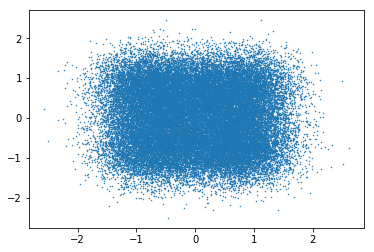

In [7]:
#project on the first two dimensions
plot(r[0,:],r[1,:],'.',markersize=1);

## Define a function for approximating Kmeans++

In [8]:
def D(p,Centers):
    # find the minimal square distance between a point p and a set of points: Centers
    diff=p-Centers
    dists=sum(diff**2,axis=0)
    return min(dists)
Centers=r[:,0:1]
p=r[:,1:2]
D(p,Centers)

182.52674246076452

In [9]:
def KPP(r,fraction=0.1):
    d_list=[]
    Max_list=[]
    cent_no_list=[]
    Prob_list=[]
    
    Centers=r[:,0:1]
    Max=100
    N=r.shape[1]

    print('epoch\tcenters\tdist\t\tMax\t\tProb')
    epoch=0;
    i=0;
    while Centers.shape[1]<N*fraction:
        point=r[:,i:i+1]
        d=D(point,Centers)
        d_list.append(sqrt(d))
        Pr=d/Max
        Prob_list.append(Pr)

        if random.rand()<Pr:
            Centers=append(Centers,point,axis=1)

        cent_no_list.append(Centers.shape[1])
        Max_list.append(sqrt(Max))

        # Heuristics for choosing the normalization
        if Pr > 0.25:
            Max*=2
        else:
            Max*=0.99
            
        # go to next example or loop
        i+=1
        if i==N:
            i=0
            epoch+=1
            print('%d\t%d\t%7.6f\t%7.6f\t%7.6f'%(epoch,Centers.shape[1],sqrt(d),Max,Pr))

            
    return Centers, d_list, Max_list, cent_no_list, Prob_list


```python
while Centers.shape[1]<N*fraction:
        point=r[:,i:i+1]   # get the next point from r
        d=D(point,Centers) # Compute the distance to the closest centroid
        Pr=d/Max           # Inrease the probability (but not beyond 1)
        if random.rand()<Pr:  # flip a coin with prob(heads)=Pr
            Centers=append(Centers,point,axis=1) # if heads: add point to centroids
```

```python
# Heuristics for choosing the normalization
        if Pr > 0.25:
            Max*=2    #increase if too small
        else:
            Max*=0.99 #decrease if too large
```            


## Run Kpp

In [10]:
Centers, d_list, Max_list, cent_no_list, Prob_list = KPP(r)

epoch	centers	dist		Max		Prob


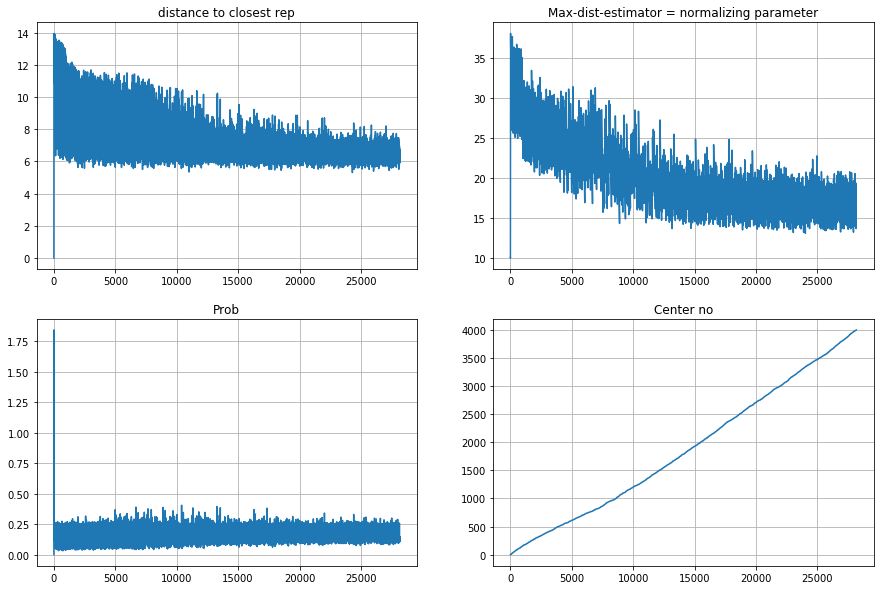

In [11]:
figure(figsize=[15,10])

subplot(2,2,1)
plot(d_list)
title('distance to closest rep')
grid()
subplot(2,2,2)
plot(Max_list)
title('Max-dist-estimator = normalizing parameter')
#ylim([0,5])
grid()
subplot(2,2,3)
plot(Prob_list)
title('Prob')
grid()
subplot(2,2,4)
plot(cent_no_list)
title('Center no')
grid()

## reduce the noise of the distance sequence
To compute the RMSE exactly, we need to scan the whole dataset.

We use an approximation based on the recent measurements.

We smooth by convolving the sequence with windows of increasing length.

28162
1 10 1000 990 (990,) (28162,)
2 100 10000 9900 (9900,) (28162,)
3 1000 28162 27162 (28661,) (28162,)


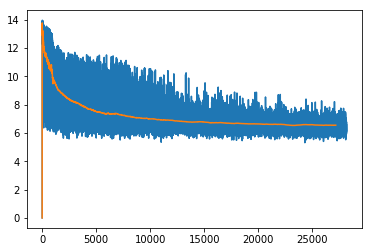

In [12]:
d_array=np.array(d_list)
L=d_array.shape[0]
print(L)
c=d_array*1.0
i=1
sm = d_array*1.
mode='valid'
P=10;
while True:
    b=P**i
    if b>L:
        break
    _from=b
    _to=b*10*P
    if _to>L:
        _to=L
        mode='full'
    filt=ones(b)/b
    cc=convolve(d_array[int(_from-b/2):int(_to+b/2)-1],filt,mode)
    print(i,_from,_to,_to-_from,cc.shape,c.shape)
    if _to!=L:
        c[_from:_to] = cc[:_to-_from]
    else:
        c[_from:_to] = cc[b:_to-_from+b]
        c=c[:-b]
        break
    i+=1
plot(d_array)
plot(c)

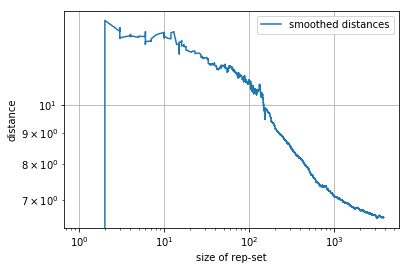

In [13]:
cent_no_list=cent_no_list[:c.shape[0]]
loglog(cent_no_list,c,label='smoothed distances')
#loglog(cent_no_list,d_list)
#loglog(cent_no_list,Max_list,label='Max estimator')
grid()
xlabel('size of rep-set')
ylabel('distance')
legend();

## Finally, compute an estimate of the intrinsic dimension
We pick two values for the number of centroids: `N1,N2` and use the log ratio formula

In [14]:
def estimate_dim(cent_no_list,filt_d):
    N=len(cent_no_list);N1=int(0.1*N);N2=int(N-1)
    return (log(cent_no_list[N1])-log(cent_no_list[N2]))/(log(filt_d[N2])-log(filt_d[N1]))

In [15]:
estimate_dim(cent_no_list,c)

10.01038054666019

## Summary
* We saw how to use Kmeans++ to estimate intrinsic dimension
* In order for the sampling to be efficient we continuousl estimate the max distance.
* To estimate the dimension we need to use a smoothed version of the distances.


## Next
We will rerun this notebook on different datasets to estimate their intrinsic dimension.